## Dogs vs Cats with Pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, copy, math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [2]:
data_dir = './data/train'
cat_files = [tf for tf in os.listdir(data_dir) if 'cat' in tf]
dog_files = [tf for tf in os.listdir(data_dir) if 'dog' in tf]

In [3]:
import random
random.seed(2020)
val_indices = random.sample(range(0,len(cat_files)),1000)
val_cats_file = [cat_files[i] for i in val_indices]
val_dogs_file = [dog_files[i] for i in val_indices]

train_cats_file = [cat_files[i] for i in range(len(cat_files)) if i not in val_indices]
train_dogs_file = [dog_files[i] for i in range(len(dog_files)) if i not in val_indices]

In [8]:
training_transform_pipeline=transforms.Compose([
    transforms.RandomRotation(5), # some rotation
    transforms.RandomHorizontalFlip(), # random flipping
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)), # resize cropping
    # the ratio is 0.96-1.0 to avoid cutting off important features like Head of dog/cat
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # the normalization mean and std are recommended to work well
])

val_transform_pipeline=transforms.Compose([
    # just crop and normalization for val set
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)), # resize cropping
    # the ratio is 0.96-1.0 to avoid cutting off important features like Head of dog/cat
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # the normalization mean and std are recommended to work well
])

In [9]:
class CatDogDataset(Dataset):
    def __init__(self,file_list,dir, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        self.dir = dir
        self.file_list = file_list
        
        if mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        '''
        return the tensor and label (None for val set)
        '''
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        img = self.transform(img)
        if self.mode == 'train':
            return img, self.label
        else:
            return img, -1


In [6]:
train_cats = CatDogDataset(train_cats_file,data_dir,transform=training_transform_pipeline)
train_dogs = CatDogDataset(train_dogs_file,data_dir,transform=training_transform_pipeline)
train_catdogs = ConcatDataset([train_cats, train_dogs]) # concat two dataset

In [7]:
val_cats = CatDogDataset(val_cats_file,data_dir,transform=val_transform_pipeline)
val_dogs = CatDogDataset(val_dogs_file,data_dir,transform=val_transform_pipeline)
val_catdogs = ConcatDataset([val_cats, val_dogs]) # concat two dataset

In [8]:
train_dataloader = DataLoader(train_catdogs, batch_size = BATCH_SIZE, shuffle=True) #  , num_workers=4
val_dataloader = DataLoader(val_catdogs,batch_size=BATCH_SIZE,shuffle=False)

In [9]:
dataloader = {'train':train_dataloader,'val':val_dataloader}

In [12]:
def imshow(tup):
    """Imshow for Tensor."""
    inp, label = tup
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if label==1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.pause(0.001)  # pause a bit so that plots are updated

# imshow(catdogs[0])

### Model Training and Validation

In [10]:
def train_with_val(model, loss_fn, optimizer, scheduler, num_epochs, best_loss=math.inf, best_acc=0.,best_model_wts=None):
    
    if best_model_wts == None:
            best_model_wts = copy.deepcopy(model.state_dict())
    
    start_time = time.time()
    
    training_errors = []
    validation_errors = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for mode in ['train', 'val']:
            # change model mode
            if mode == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloader[mode]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(mode == 'train'):  # if training
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    if mode == 'train':  # forward
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                    # compare predictions and gt
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
            # calculate epoch level stats
            epoch_loss = running_loss / len(dataloader[mode].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[mode].dataset)
            
            print('Mode {}, Loss: {:.4f} Acc: {:.4f}'.format(
                mode, epoch_loss, epoch_acc))
            
            if mode == 'val' and epoch_loss < best_loss:
                print()
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if mode == 'train':
                training_errors.append(epoch_loss)
            else:
                validation_errors.append(epoch_loss)
            
        time_elapsed = time.time() - start_time
        print('Training has been for {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()

    
    return model, best_loss, best_acc, best_model_wts, training_errors, validation_errors

In [73]:
model_conv = torchvision.models.resnet101(pretrained=True)

In [12]:
for param in model_conv.parameters(): 
    param.requires_grad = False # do not change the parameter in the pretrained model

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features # get the number of features before the last layer
model_conv.fc = nn.Linear(num_ftrs, 2) # modify the last layer

model_conv = model_conv.to(device)

In [74]:
loss_fn = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### First time training

In [20]:
EPOCH_NUM = 30

In [14]:
model_conv_trained, best_loss, best_acc, best_model_wts, training_errors, validation_errors = train_with_val(
                                                         model_conv,
                                                         loss_fn,
                                                         optimizer_conv,
                                                         exp_lr_scheduler,
                                                         num_epochs=EPOCH_NUM)
# start time 14:08, about 7-8 min per epoch


Epoch 1/30
----------
Mode train, Loss: 0.5165 Acc: 0.8829
Mode val, Loss: 0.5212 Acc: 0.8775

New best model found!
New record loss: 0.5211651968955994, previous record loss: inf
Training has been for 9m 50s

Epoch 2/30
----------
Mode train, Loss: 0.5153 Acc: 0.8861
Mode val, Loss: 0.5177 Acc: 0.8815

New best model found!
New record loss: 0.5177491798400878, previous record loss: 0.5211651968955994
Training has been for 18m 50s

Epoch 3/30
----------
Mode train, Loss: 0.5153 Acc: 0.8870
Mode val, Loss: 0.5193 Acc: 0.8875
Training has been for 27m 39s

Epoch 4/30
----------
Mode train, Loss: 0.5148 Acc: 0.8870
Mode val, Loss: 0.5207 Acc: 0.8800
Training has been for 36m 40s

Epoch 5/30
----------
Mode train, Loss: 0.5147 Acc: 0.8847
Mode val, Loss: 0.5209 Acc: 0.8800
Training has been for 45m 40s

Epoch 6/30
----------
Mode train, Loss: 0.5143 Acc: 0.8864
Mode val, Loss: 0.5182 Acc: 0.8855
Training has been for 54m 42s

Epoch 7/30
----------
Mode train, Loss: 0.5141 Acc: 0.8877
Mode 

In [15]:
print(best_loss, best_acc)

0.5157223091125488 tensor(0.8815, device='cuda:0', dtype=torch.float64)


In [16]:
torch.save(model_conv_trained.state_dict(), './30epoch')

torch.save(best_model_wts,'./best_model')

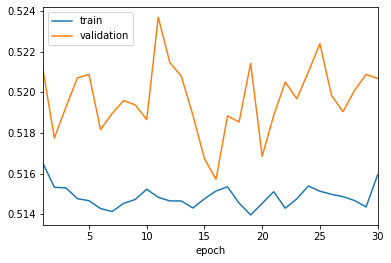

In [21]:
errors = pd.DataFrame() 
errors['epoch'] = list(range(1,EPOCH_NUM+1))
errors['train'] = training_errors
errors['validation'] = validation_errors

errors = errors.set_index(errors.epoch,drop=True)
errors.drop('epoch',axis=1,inplace=True)
errors.plot()

In [23]:
import pickle

pickle.dump(errors,open('30EpochErrors.p','wb'))
pickle.dump((best_loss,best_acc),open('best_results.p','wb') )

#### Further training on trained models

In [14]:
EPOCH_NUM = 30

In [2]:
import pickle

errors = pickle.load(open('./pickles/EpochErrors.p','rb'))
(best_loss,best_acc) = pickle.load(open('./pickles/best_results.p','rb') )

In [16]:
# to load previously trained model for further training

model_conv.load_state_dict(torch.load('./model/90epoch'))

<All keys matched successfully>

In [17]:
model_conv_trained, best_loss, best_acc, best_model_wts, training_errors, validation_errors = train_with_val(model_conv,
                                                         loss_fn,
                                                         optimizer_conv,
                                                         exp_lr_scheduler,
                                                         num_epochs=EPOCH_NUM,
                                                         best_loss=best_loss,
                                                         best_acc=best_acc,
                                                         best_model_wts = torch.load('./model/best_model'))

Epoch 1/30
----------
Mode train, Loss: 0.3360 Acc: 0.9347
Mode val, Loss: 0.3356 Acc: 0.9335

New best model found!
New record loss: 0.3355845034122467, previous record loss: 0.3969363210201263
Training has been for 8m 19s

Epoch 2/30
----------
Mode train, Loss: 0.3366 Acc: 0.9361
Mode val, Loss: 0.3332 Acc: 0.9370

New best model found!
New record loss: 0.3332375690937042, previous record loss: 0.3355845034122467
Training has been for 16m 9s

Epoch 3/30
----------
Mode train, Loss: 0.3379 Acc: 0.9349
Mode val, Loss: 0.3317 Acc: 0.9435

New best model found!
New record loss: 0.33173141169548037, previous record loss: 0.3332375690937042
Training has been for 23m 58s

Epoch 4/30
----------
Mode train, Loss: 0.3362 Acc: 0.9367
Mode val, Loss: 0.3365 Acc: 0.9325
Training has been for 31m 47s

Epoch 5/30
----------
Mode train, Loss: 0.3369 Acc: 0.9362
Mode val, Loss: 0.3303 Acc: 0.9370

New best model found!
New record loss: 0.3302905468940735, previous record loss: 0.33173141169548037
Tr

In [18]:
print(best_loss, best_acc)
# 0.3969363210201263 tensor(0.9445, device='cuda:0', dtype=torch.float6

0.3261678011417389 tensor(0.9510, device='cuda:0', dtype=torch.float64)


In [19]:
torch.save(model_conv_trained.state_dict(), './model/120epoch')

torch.save(best_model_wts,'./model/best_model')

In [20]:
pickle.dump(errors,open('./pickles/EpochErrors.p','wb'))
pickle.dump((best_loss,best_acc),open('./pickles/best_results.p','wb') )

In [ ]:
_ = pd.DataFrame({'train':training_errors,'validation':validation_errors})
errors = pd.concat([errors,_])
errors.index = range(1,len(errors)+1)

pickle.dump(errors,open('./pickles/EpochErrors.p','wb'))

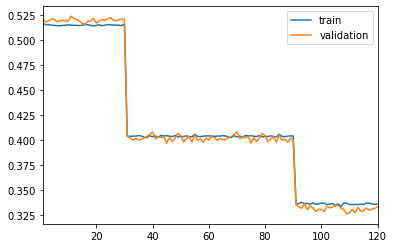

In [5]:
errors.plot()

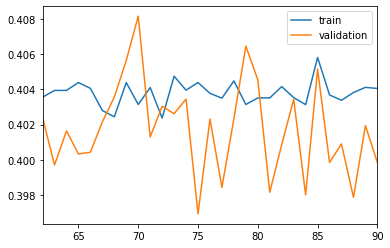

In [5]:
errors[61:90].plot()

### Run test dataset 


In [10]:
model_conv_trained = torchvision.models.resnet101(pretrained=True)

num_ftrs = model_conv_trained.fc.in_features # get the number of features before the last layer
model_conv_trained.fc = nn.Linear(num_ftrs, 2) # modify the last layer

model_conv_trained = model_conv_trained.to(device)

model_conv_trained.load_state_dict(torch.load('./model/best_model'))

<All keys matched successfully>

In [11]:
test_data_dir = './data/test'
test_files = [tf for tf in os.listdir(test_data_dir)]

In [12]:
test_dataset = CatDogDataset(test_files,test_data_dir,transform=val_transform_pipeline,mode='test')
# size 12500
len(test_dataset)

12500

In [13]:
test_dataloader =  DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [69]:
model_conv_trained.eval()
# all_preds = []
all_probs = []
for i, (inputs,_) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model_conv_trained(inputs)
        probs, preds = torch.max(torch.nn.functional.softmax(outputs,dim=1),1)
        all_probs.extend(probs.tolist())
#         all_preds.extend(preds.tolist())

In [70]:
submission_df = pd.DataFrame()
submission_df['id'] = list(range(1,len(test_files)+1))
submission_df['label'] = all_probs

In [71]:
submission_df

,id,label
0,1,0.711909
1,2,0.814382
2,3,0.869368
3,4,0.651740
4,5,0.758488
5,6,0.878054
6,7,0.748558
7,8,0.831729
8,9,0.509704
9,10,0.805781


In [72]:
submission_df.to_csv('submission.csv',index=False)